Aqui nós iremos importar toda a biblioteca necessária

In [ ]:
import torch
from PIL import Image
from torch import nn, load, save
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

Nessa etapa importaremos o dataset MNIST.

[Ler documentação](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
BATCH_SIZE = 32

# Aqui nós importamos o MNIST pra treinar, ele é importado como uma imagem PIL, nós aplicaremos a transformação para deixar ele em tensores
train = datasets.MNIST(root="data", download=True, train=True, transform=ToTensor())

# Ao invés de fazermos o modelo treinar uma imagem por vez, iremos fazê-lo ler um minipacote de 32 imagens, que depois serão embaralhadas
# diminuindo overfitting
dataset = DataLoader(train, BATCH_SIZE)

No código abaixo teremos a construção do modelo propriamente dito.

Primeiro uma camada convolucional que recebe cada "pacote" acima e aplica uma rede convolucional com kernel (3,3) em cada um, além disso, uma função de ativação ReLU

Depois uma segunda camada convolucional, assim como uma terceira (Por que a última tem 64?)

O (28-6) vem do fato de que um kernel (3x3) elimina, de cada imagem, 2 pixels. Como há três camadas convolucionais, 6 pixels ao total forem retirados da imagem no eixo X e no eixo Y.

O output é 10, no Linear, pelo fato de haver 10 possibilidades para classificar o MNIST (números de 0 a 9)

In [ ]:
class ImageClassifier(nn.Module):
  def __init__(self):
    super().__init__() # inicia o nn.Module
    self.model = nn.Sequential(
        nn.Conv2d(1, BATCH_SIZE, (3,3)),
        nn.ReLU(),
        nn.Conv2d(BATCH_SIZE, 64, (3,3)),
        nn.ReLU(),
        nn.Conv2d(64, 64, (3,3)),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64*(28-6)*(28-6), 10)

    )

  def forward(self, x):
    return self.model(x)

Iremos ler o modelo na GPU.

Aplicaremos o otimizador Adam com learning_rate de 0,001

E uma função de perda CrossEntropyLoss

In [ ]:
clf = ImageClassifier().to('cuda')
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

Abaixo, o código será treinado. Teremos 10 epochs

Links úteis:

[Por que zeramos o gradiente no PyTorch?](https://stackoverflow.com/a/48009142)

[Explicação do que opt.step() faz](https://stackoverflow.com/a/53975741)

In [ ]:
n_epochs = 10
for epoch in range(1, n_epochs+1):
  for batch in dataset: # para cada pacote no dataset....
    x,y = batch # x é a imagem convertida em Tensor, y é a classificação da imagem
    x,y = x.to('cuda'), y.to('cuda') # como ambos estão em tensor, iremos lê-lo na GPU
    yhat = clf(x) # previsão do modelo
    loss = loss_fn(yhat, y) # é aplicada a função de perda com base na classificação real da imagem e com o que o modelo previu

    opt.zero_grad() # iremos zerar o gradiente, porque não trabalhamos aqui com uma RNN
    loss.backward() # aplicamos backpropagation
    opt.step() # os parâmetros do modelo são atualizados
  print(f"Epoch {epoch}/{n_epochs}: loss {loss.item()}")

Epoch 1/10: loss 0.03375924006104469

Epoch 2/10: loss 0.0011574391974136233

Epoch 3/10: loss 0.00044446351239457726

Epoch 4/10: loss 0.0001982323738047853

Epoch 5/10: loss 1.2843447620980442e-05

Epoch 6/10: loss 1.7955768498723046e-06

Epoch 7/10: loss 1.307569050368329e-06

Epoch 8/10: loss 1.1689134225889575e-05

Epoch 9/10: loss 0.0002048220339929685

Epoch 10/10: loss 4.907594120595604e-05


Salva o modelo

In [ ]:
with open('teste.pt', 'wb') as f:
  save(clf.state_dict(), f)

Vamos agora carregar uma nova base MNIST (porque sim) só pra prever os resultados

In [ ]:
import numpy as np

test = datasets.MNIST(root='PATH', download=True, train=False, transform=ToTensor())


Failed to download (trying next):

HTTP Error 403: Forbidden






100%|██████████| 9912422/9912422 [00:01<00:00, 5078289.36it/s]


Extracting PATH/MNIST/raw/train-images-idx3-ubyte.gz to PATH/MNIST/raw




Failed to download (trying next):

HTTP Error 403: Forbidden






100%|██████████| 28881/28881 [00:00<00:00, 133940.25it/s]


Extracting PATH/MNIST/raw/train-labels-idx1-ubyte.gz to PATH/MNIST/raw




Failed to download (trying next):

HTTP Error 403: Forbidden






100%|██████████| 1648877/1648877 [00:01<00:00, 1096841.80it/s]


Extracting PATH/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH/MNIST/raw




Failed to download (trying next):

HTTP Error 403: Forbidden






100%|██████████| 4542/4542 [00:00<00:00, 4503671.10it/s]

Extracting PATH/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH/MNIST/raw




Iremos carregar o modelo que foi salvo

In [ ]:
with open('teste.pt', 'rb') as f:
  clf.load_state_dict(load(f))

Prevendo a nova MNIST

*A explicação abaixo era no caso de você carregar uma imagem PIL em x e depois ter que transforma-lá em tensor. A diferença agora é que já lemos o dataset de teste como Tensor, só restando então o unsqueeze*

O que acontece nesse trecho?
```
ToTensor()(x).unsqueeze(0).to('cuda')
```
Basicamente, a imagem carregada será  transformada em um tensor e depois colocada em um "pacote" que só tem ela mesmo, mais quantas cores tem nessa imagem (no caso, 1) e as dimensões dela. Isto é: [N, C, W, H] = [1, 1, 28, 28]

[Mais informações](https://stackoverflow.com/a/68824773)

Além disso, esse tensor é lido na GPU


In [ ]:
def prever(img):
  return torch.argmax(clf(img.unsqueeze(0).to('cuda')))

# o modelo atribui uma probabilidade a cada uma das classes, o que estamos
# fazendo aqui é apenas selecionar qual classe teve a maior prob.

Vamos ver um figurão com 9 imagens e suas previsões

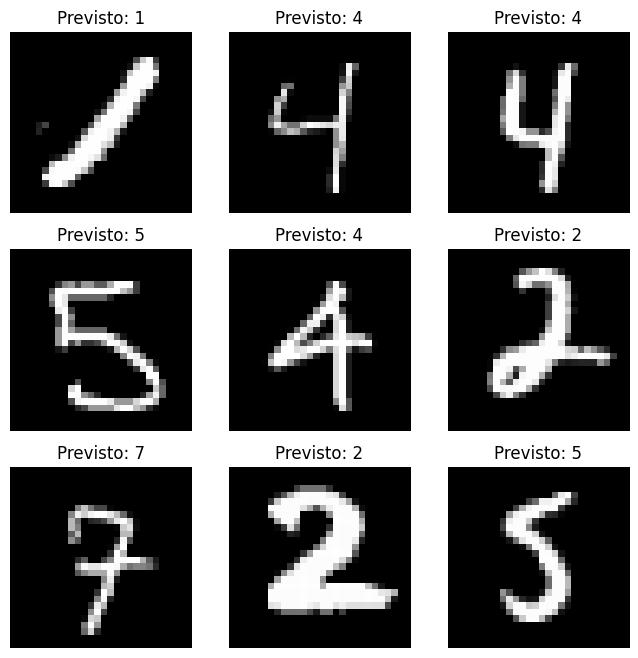

In [ ]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3 # colunas, linhas
for i in range(1, cols*rows + 1): # para cada figurazinha que será colocada
  sample_i = np.random.randint(len(test)) # número inteiro aleatório
  img, label = test[sample_i]
  previsao = prever(img)

  figure.add_subplot(rows, cols, i)
  plt.title(f'Previsto: {previsao}')
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()